## Afandi Mohammad  
## Hu Pauline

# Convolutional Neural Networks (CNN) and Deep Architectures

In these practicals, we will create a first convolutional neural network (CNN). This type of networks mostly rely on alternating layers of convolution and pooling. A convolution layer is a signal processing inspired layer that performs a bunch of convolutions on the layer input and yields filtered outputs known as feature maps. A pooling layer is a sort of subsampling layer. Most of the time, after several Conv/Pool layer pairs, a usual MLP is plugged to obtain class membership probabilities. When the number of layers is rather high (unclear how high this is), we obtain a deep network.

We will use `TensorFlow` as programming framework and build a CNN to solve an image classification task.

## Starting with TensorFlow

`TensorFlow` is Google's library designed to create and train deep nets. It relies on symbolic programming and on the notion of computation graph. Here is an example of such a graph:

<img src="graph.png" alt="drawing" width="200"/>

In this graph, we prepare `TensorFlow` to later compute the following function :

$$f\left( x,y\right) = x^2 + 2y,$$

for some $x$ and $y$. In this graph, the variables $x$ and $y$ are instances of the `tf.placeholder` class. Given these two objects, programming function $f$ is quite easy. We just need one line of code to explain `TensorFlow` how to compute $f\left( x,y\right)$ given $x$ and $y$:

```python
f = x*x + 2*y
```

This is done in a symbolic way meaning that $+$ here is not the usual Python + but `TensorFlow`'s addition operator. 

There are consequently two programming phases when using `TensorFlow`:
* graph building and variable declaration,
* actual computation performed as part of a `session`.

Here is the full code to build the graph for function $f$ followed by a `session` to compute function values for some $(x,y)$ pairs.

In [1]:
import tensorflow as tf

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# creates the variable container
x = tf.placeholder(tf.float32,shape=[])
y = tf.placeholder(tf.float32,shape=[])
f = x*x + 2*y
some_x = [1,2,3]
some_y = [2,3,4]

with tf.Session() as sess:
    for i in range(len(some_x)):
        print(sess.run(f,feed_dict={x: some_x[i],y: some_y[i]})) # sets the variable's values and computes

5.0
10.0
17.0


The `tf.placeholder` class is meant to define variables that will be later replaced with data streams. Here, we specified that these data are `float32` and that they are scalars (`shape=[]`). In the `session`, we explain `TensorFlow` that the `x` and `y` will now be replaced by some specific values which we defined before as integer lists. 

### Q1
* Define in a symbolic way the gradient of function $f$ (see `TensorFlow.gradients` documentation) and compute the gradient vectors for the same $(x,y)$ pairs as in the above code. 


---

In [3]:
# computes the gradient of the f function
gradf = tf.gradients(f, [x,y])

with tf.Session() as sess:
    for i in range(len(some_x)):
        print(sess.run(gradf,feed_dict={x: some_x[i],y: some_y[i]}))

[2.0, 2.0]
[4.0, 2.0]
[6.0, 2.0]


---

## Baseline CNN

We are now almost ready to start building a `TensorFlow` graph containing convolution or pooling layers instead of the basic operations involved in function $f$. Unlike function $f$, the classification function that we are trying to learn is parametric. Parameters can be explicitely defined as `TensorFlow` variables which are instances of the `tf.Variable` class. Since the backpropagation cannot work if parameters are not intialized, we will be using an initializer provided by `TensorFlow`. However, we will not explicitely define parameters but instead use `TensorFlow` macroscopic layerwise functions which encompass `TensorFlow` variables. This makes the code much simpler but less modular.

But first things first ! We need a dataset to work with and to load in Jupyter. We will be working with the `MNIST` dataset. This dataset contains 28x28 grayscale images of handwritten figures. It has the advantage to be larger than traditional datasets utilized in practicals while it can still hold in memory and converge in a few minutes. Larger or more complicated datasets (more variability in images) would require too many computational efforts.

Download the `MNIST` archive at [mnist.pkl.gz](http://deeplearning.net/data/mnist/mnist.pkl.gz). Load the dataset using the `load_mnist` function. You need to feed it with the path to the `MNIST` archive.

In [37]:
import numpy as np
import sys
from matplotlib.pyplot import imshow
import gzip
import _pickle as cPickle # for serialization (convert data to byte)

def load_mnist(filename):
    f = gzip.open(filename, 'rb')
    # the train, validation and test sets contain two arrays : the data with feature values and the target values
    # train set 50000 values
    # validation set : 10000 values
    # test set : 10000 values
    train_set, valid_set, test_set = cPickle.load(f, encoding='iso-8859-1')
    f.close()
    X = np.vstack((train_set[0],valid_set[0]))
    y = np.hstack((train_set[1],valid_set[1]))
    X_test = test_set[0]
    y_test = test_set[1]
    return X,y,X_test,y_test

# Load the mnist package and assign train, test sets and targets
X,y,X_test,y_test = load_mnist('mnist.pkl.gz')


In [ ]:
# set the seed
np.random.seed(1)  # for numpy fuctions
tf.set_random_seed(1234)  # for tensorflow functions

In [ ]:
# shuffle the data first!
index = np.arange(len(X))
np.random.shuffle(index)
X = X[index]
y = y[index]

The rows in X have been shuffled.

### Q2
* Reshape `X` and `X_test` so that they have shape (60000,28,28,1) and (10000,28,28,1) respectively.


---

In [38]:
# reshapping each row of X to get the shape of an image
X = np.reshape(X,(60000,28,28,1))
X_test = np.reshape(X_test,(10000,28,28,1))

We can now begin to build the CNN. At the start of the `TensorFlow` graph we need to define data containers, i.e. instances of `tf.placeholder`. We will use mini-batch gradient descent to optimize the NN parameters and we want the code to be modular so we cannot specify the first dimension of the tensor containing training examples. `TensorFlow` allows this :

In [39]:
# creating the variable
tf.reset_default_graph()
Xtf = tf.placeholder(tf.float32,shape=[None, X.shape[1], X.shape[2],1]) # Xtf contains a modulable number of 28x28 arrays (the mnist images)
ytf = tf.placeholder(tf.int64,shape=[None, ])

The next element of our NN is a 2D convolutional layer. We can use an instance of the `tf.layers.conv2d` class. We need to specify that a `tf.placeholder` instance is the input, the number of size of filters (kernels) that we want, how to deal with image borders (padding) and what activation we would like. This gives:

In [40]:
# Convolutional Layer #1
conv1 = tf.layers.conv2d(
      inputs=Xtf,
      filters=64,
      kernel_size=[5, 5], # size of the convolution window
      padding="same",  # how to handle borders ('valid': ignores sides values if filter size and strides aren't fit to go theough the entire image,
                       #                        'same': adds dummy values to convolve through the entire image)
      activation=tf.nn.relu)

Next, we need a pooling layer to give up some entries of the filtered images provided by the convolutional layer. We will use the usual max pool function in 2x2 neighborhoods which drops 3 entries out of 4 in each such neighborhood. The remaining entry is the one achieving maximal value in the neighborhood.

In [41]:
# Pooling Layer #1
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

### Q3
* What is the role of parameter `strides` ? 
* What is the size of each feature map after max pooling ?
* How many feature maps are there ?

**Aswer Q3:**  
* Stride controls how the filter convolves around the input volume. The amount by which the filter shifts is the stride. Stride is normally set in a way so that the output volume is an integer and not a fraction. It can be interpreted as the step of the filter.
* The size of each feature map after max pooling is 14x14.
Indeed the feature map contains the values of each convolution the filter computes while going though the entire image. If the image size was 28x28, the filter size 5x5, the stride 1 and the padding set to 'valid', the filter would go through $(28-5+1) \times (28-5+1)$ different locations. The feature map size would be 24x24.    
Here the padding is set to 'same'. This means he output has the same size as the intput : 28x28.  
The basic pooling method consists in applying a filter with a stride of same length on the feature map. For each stride, we keep the highest value. The new feature map has its size reduced.
Indeed applying a pooling layer on the feature map helps reducing the amount of data in the feature map while preserving its global structure. It also helps with overfitting since it only keeps important values and removes less important ones. In our case we have a pool filter of size 2x2, a feature map of size 28x28 and a stride of 2. The final feature map is of size $(28*28)/ ((4/2)*(4/2))$: 14x14.
* There are 64 different feature maps.

---

We will now plug a 1 layer MLP (multilayer perceptron) on top of this. Fully connected layers (or dense layers) do not accept numpy ndarrays. We can use tf.reshape to flatten feature maps. In the following code the scalar dflat = nbr of feature maps x feature map width x feature map height. Set this variable with the correct value and execute the following code line:

In [42]:
# flatten pooled array for MLP
dflat = 64*14*14
pool1_flat = tf.reshape(pool1, [-1, dflat])

Now the one layer MLP is given by an instance of `tf.layers.dense` as:

In [43]:
# add one hidden layer with 1024 neurons
mlp = tf.layers.dense(inputs=pool1_flat, units=1024, activation=tf.nn.relu)

Finally, we need a softmax regression function to obtain class membership probabilities. This can be done in this way:

In [44]:
# apply classification function : logit (logistic regression generalization for K > 2 classes)
logits = tf.layers.dense(inputs=mlp, units=10) 
smax = tf.nn.softmax(logits)

### Q4
* How many parameters is there in our NN ?


---
**NN parameters :** 
- convolution : size of convolution window, stride, how to handle borders, number of filters
- pooling : size of pooling window, stride and how to handle borders
- activation function 
- classification function
- size of the mini-batch
- optimizer learning rate
---

Actually, the utimate element of the `TensorFlow` graph is the loss. In softmax (or logistic) regression, the corresponding loss is the cross entropy. A numerically stable version of this loss is given by `tf.losses.sparse_softmax_cross_entropy`:

In [45]:
# computes the loss function for training (on logits because losses.sparse_softmax_cross_entropy already applies smax)
loss = tf.losses.sparse_softmax_cross_entropy(labels=ytf, logits=logits) 

Now that we have completed the graph, we can move to the next phase: actually training the NN. Prior to entering the training loop, we need to instantiate an optimizer from `TensorFlow` and ask him to minimize the loss. We will use the ADAM optimizer which is robust and easy to tune.

In [46]:
# set the optimizer used for the backpropagation
learning_rate = 0.01
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss) 
init = tf.global_variables_initializer()

Adam optimization algorithm is different from stochastical gradient descent in that it changes the learning rate (speed of descent) at each step of the descent.

An initializer has also been instantiated. Indeed parameters are hidden in instances of our NN layers but they need initialization anyway.

We can now begin to iterate on training examples. We will select mini-batches of training examples. Once each training example has been processed as part of the backpropagation algorithm, a training epoch is completed. It is quite common to iterate on epochs, and in each epoch on mini-batches. 

The following code lines are in line with this habit. There are only two lines to complete to make it work. They correpond to the selection of training examples in each mini-batch. 

### Q5
* Fulfill correctly the missing parts of these instructions.
**Warning** : the execution of the loop takes around 5mn. The gradient descent should achieve approximately a 0.13 loss or below (remember this is stochastic).

In [47]:
# Accuracy metrics
correct_prediction = tf.equal(tf.argmax(logits,1), ytf) # get the predicted target with maximum weigth with argmax and compare it to the real target value
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))   # casting the correct_prediction to float

In [48]:
n_epochs = 2
batch_size = 150
n = len(X)

with tf.Session() as sess:
    init.run()
    
    # training cycles
    for epoch in range(n_epochs):
        n_batches = n // batch_size
        
        # Loop over all batches
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()  # fluhing the buffer 
            X_batch = X[iteration*batch_size : (iteration+1)*batch_size]
            y_batch = y[iteration*batch_size : (iteration+1)*batch_size]
            sess.run(training_op, feed_dict={Xtf: X_batch,ytf: y_batch})  # running the optimizer
                        
        loss_train = loss.eval(feed_dict={Xtf: X_batch,ytf: y_batch})
        train_accuracy = sess.run(accuracy,feed_dict={Xtf: X_batch,ytf: y_batch}) # compute training accuracy
        print("\r{}".format(epoch), "Train loss:", loss_train , ", Accuracy:", train_accuracy)
        
    test_accuracy = sess.run(accuracy,feed_dict={Xtf: X_test,ytf: y_test})
    print("\nTest Accuracy", test_accuracy)

0 Train loss: 0.12863576 , Accuracy: 0.9866667
1 Train loss: 0.08623568 , Accuracy: 0.99333334

Test Accuracy 0.9794


### Q6
* Document yourselves on means to compute the classifier accuracy using `TensorFlow` functions. 
* Add the corresponding functions to the graph.
* Modify the loop to evaluate the classifier accuracy on the test set. 
* Comment on the quality of the learning.

---
The train loss during the second execution of the training is lower because the NN has already been trained on the train set one time. Training NN networks two times rises the train accuracy too. 

The test accuracy rate is very good, meaning the built model hasn't been overfitted. 

---

### Q7
* Add a second pair of conv/pool layers. A smaller amount of filters and smaller filters are recommended.

In [66]:
tf.reset_default_graph()
Xtf = tf.placeholder(tf.float32,shape=[None, X.shape[1], X.shape[2],1])
ytf = tf.placeholder(tf.int64,shape=[None, ])

# Convolutional Layer #1
conv1 = tf.layers.conv2d(
      inputs=Xtf,
      filters=64,
      kernel_size=[5, 5], # size of the convolution window
      padding="same",  # how to handle borders ('valid': ignores sides values if filter size and strides aren't fit to go theough the entire image,
                       #                        'same': adds dummy values to convolve through the entire image)
      activation=tf.nn.relu)

# Pooling Layer #1
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

# Convolutional Layer #2
conv2 = tf.layers.conv2d(
      inputs=pool1, # added on top of first layer
      filters=32,
      kernel_size=[3, 3], # size of the convolution window (smaller window)
      padding="same",  # how to handle borders ('valid': ignores sides values if filter size and strides aren't fit to go theough the entire image,
                       #                        'same': adds dummy values to convolve through the entire image)
      activation=tf.nn.relu)

# conv2 has same height and width as pool1 (14x14)

# Pooling Layer #2
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

# Flatten pooled array for MLP: pool2 applies a 50% reduction of height and width from conv2
dflat2 = 32*7*7
pool2_flat = tf.reshape(pool2, [-1, dflat2])

### Q8
* Add a second fully connected layer. A smaller number of units is recommended.

In [67]:
# Add one hidden layer with 1024 neurons
mlp1 = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
# Add another hidden layer on top of the first one with 128 neurons
mlp2 = tf.layers.dense(inputs=mlp1, units=128, activation=tf.nn.relu)

# Apply classification function : logit (logistic regression generalization for K > 2 classes)
logits = tf.layers.dense(inputs=mlp2, units=10) 
smax = tf.nn.softmax(logits)

# Computes the loss function for training
loss = tf.losses.sparse_softmax_cross_entropy(labels=ytf, logits=logits)

# Set the optimizer used for the backpropagation
training_op = optimizer.minimize(loss) 

# Accuracy metrics
correct_prediction = tf.equal(tf.argmax(logits,1), ytf)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Variables initializer
init = tf.global_variables_initializer()


In [68]:
# Training graph with 2 layers

n_epochs = 2
batch_size = 150
n = len(X)

with tf.Session() as sess:
    init.run()
    
    # training cycles
    for epoch in range(n_epochs):
        n_batches = n // batch_size
        
        # Loop over all batches
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()  # fluhing the buffer 
            X_batch = X[iteration*batch_size : (iteration+1)*batch_size]
            y_batch = y[iteration*batch_size : (iteration+1)*batch_size]
            sess.run(training_op, feed_dict={Xtf: X_batch,ytf: y_batch})  # running the optimizer
                        
        loss_train = loss.eval(feed_dict={Xtf: X_batch,ytf: y_batch})
        train_accuracy = sess.run(accuracy,feed_dict={Xtf: X_batch,ytf: y_batch}) # compute training accuracy
        print("\r{}".format(epoch), "Train loss:", loss_train , ", Accuracy:", train_accuracy)
        
    test_accuracy = sess.run(accuracy,feed_dict={Xtf: X_test,ytf: y_test})
    print("\nTest Accuracy", test_accuracy)

0 Train loss: 0.112862 , Accuracy: 0.99333334
1 Train loss: 0.0792609 , Accuracy: 0.99333334

Test Accuracy 0.9859


By adding more layers, we've been able to get better loss and accuracy results.  However, it also causes the training phase to take longer.

---
### Q9
From the above NN architecture, try to tweak the other hyperparameters. These latter include:
* the learning rate,
* the mini batch size,
* the regularization strength (if regularization is activated),
* number of filters,
* filter sizes,
* activiation functions,
* strides,
* padding types,
* ...

In [69]:
def nn_2layers(X, y, X_test, y_test, learning_rate, batch_size):
  
    conv1 = tf.layers.conv2d(
        inputs=Xtf,
        filters=64,
        kernel_size=[5, 5], 
        padding="same",  
        activation=tf.nn.relu)

    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    conv2 = tf.layers.conv2d(
        inputs=pool1, 
        filters=32,
        kernel_size=[3, 3], 
        padding="same",  
        activation=tf.nn.relu)

    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    dflat2 = 32*7*7
    pool_flat = tf.reshape(pool2, [-1, dflat2])

    mlp1 = tf.layers.dense(inputs=pool_flat, units=1024, activation=tf.nn.relu)
    mlp2 = tf.layers.dense(inputs=mlp1, units=128, activation=tf.nn.relu)

    logits = tf.layers.dense(inputs=mlp2, units=10) 
    smax = tf.nn.softmax(logits)

    loss = tf.losses.sparse_softmax_cross_entropy(labels=ytf, logits=logits) 

    training_op = tf.train.AdamOptimizer(learning_rate).minimize(loss) 

    correct_prediction = tf.equal(tf.argmax(logits,1), ytf)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    init = tf.global_variables_initializer()

    n_epochs = 2
    n = len(X)

    with tf.Session() as sess:
        init.run()

        # training cycles
        for epoch in range(n_epochs):
            n_batches = n // batch_size

            # Loop over all batches
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()  # fluhing the buffer 
                X_batch = X[iteration*batch_size : (iteration+1)*batch_size]
                y_batch = y[iteration*batch_size : (iteration+1)*batch_size]
                sess.run(training_op, feed_dict={Xtf: X_batch,ytf: y_batch})  # running the optimizer

            loss_train = loss.eval(feed_dict={Xtf: X_batch, ytf: y_batch})
            train_accuracy = sess.run(accuracy,feed_dict={Xtf: X_batch,ytf: y_batch}) # compute training accuracy
            print("\r{}".format(epoch), "Train loss:", loss_train , ", Train accuracy:", train_accuracy)

        test_accuracy = sess.run(accuracy,feed_dict={Xtf: X_test, ytf: y_test})
        print("\nTest Accuracy", test_accuracy)

    return test_accuracy
      

In [70]:
tf.reset_default_graph()
Xtf = tf.placeholder(tf.float32,shape=[None, X.shape[1], X.shape[2],1])
ytf = tf.placeholder(tf.int64,shape=[None, ])
nn_2layers(X, y, X_test, y_test, learning_rate = 0.01, batch_size = 150)

0 Train loss: 0.11862265 , Train accuracy: 0.9866667
1 Train loss: 0.112266056 , Train accuracy: 0.99333334

Test Accuracy 0.9742


0.9742

In [77]:
import matplotlib.pyplot as plt

Let's assess the learning rate:

In [74]:
learning_rates = [1e-4, 1e-3, 1e-2, 1e-1]
learning_rate_acc = np.zeros(len(learning_rates))

for i, rate in enumerate(learning_rates):
    tf.reset_default_graph()
    Xtf = tf.placeholder(tf.float32,shape=[None, X.shape[1], X.shape[2],1])
    ytf = tf.placeholder(tf.int64,shape=[None, ])
    learning_rate_acc[i] = nn_2layers(X, y, X_test, y_test, learning_rate = rate, batch_size = 150)    

0 Train loss: 0.16074069 , Train accuracy: 0.9866667
1 Train loss: 0.14980233 , Train accuracy: 0.9866667

Test Accuracy 0.9683
0 Train loss: 0.11688807 , Train accuracy: 0.99333334
1 Train loss: 0.111937754 , Train accuracy: 0.99333334

Test Accuracy 0.9855
0 Train loss: 0.3298403 , Train accuracy: 0.9266667
1 Train loss: 0.112037696 , Train accuracy: 0.99333334

Test Accuracy 0.9658
0 Train loss: 2.3061216 , Train accuracy: 0.10666667
1 Train loss: 2.3062003 , Train accuracy: 0.10666667

Test Accuracy 0.101


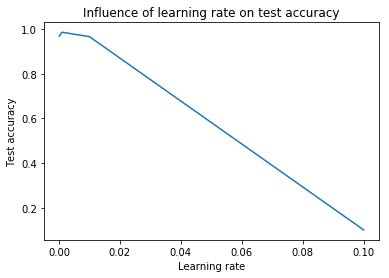

In [88]:
plt.plot(learning_rates,learning_rate_acc)
plt.xlabel("Learning rate")
plt.ylabel("Test accuracy")
plt.title("Influence of learning rate on test accuracy")
plt.show()

It seems the learning rate should be kept between 1e-4 and 1e-3.  
The last value is rather strange, we wouldn't expect such a drop in performances.

We can also try to tweak the size of the batches:

In [75]:
l_batch_sizes = [30000, 10000, 1000, 100]
l_batch_sizes_acc = np.zeros(len(learning_rates))

for i,size in enumerate(l_batch_sizes):
    tf.reset_default_graph()
    Xtf = tf.placeholder(tf.float32,shape=[None, X.shape[1], X.shape[2],1])
    ytf = tf.placeholder(tf.int64,shape=[None, ])
    l_batch_sizes_acc[i] = nn_2layers(X, y, X_test, y_test, learning_rate = 0.01, batch_size = size) 

0 Train loss: 6.818976 , Train accuracy: 0.098733336
1 Train loss: 2.3034468 , Train accuracy: 0.17096667

Test Accuracy 0.1736
0 Train loss: 2.2385414 , Train accuracy: 0.1827
1 Train loss: 0.93954235 , Train accuracy: 0.6911

Test Accuracy 0.6754
0 Train loss: 2.3030875 , Train accuracy: 0.107
1 Train loss: 2.302242 , Train accuracy: 0.107

Test Accuracy 0.1028
0 Train loss: 0.12807916 , Train accuracy: 0.97
1 Train loss: 0.15642028 , Train accuracy: 0.99

Test Accuracy 0.9554


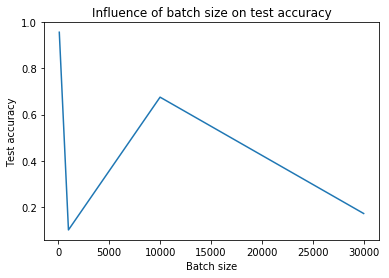

In [84]:
plt.plot(l_batch_sizes,l_batch_sizes_acc)
plt.xlabel("Batch size")
plt.ylabel("Test accuracy")
plt.title("Influence of batch size on test accuracy")
plt.show()

In this case, the lower the better, even though that means more optimizing steps.

---
These results should be taken with a grain of salt, as we've only been able to run a few simulations because of how long each one takes.  
Furthermore, we've also noticed that our simulations would randomly return inconsistant values after a given time. This may have to do with the tensorflow library or our personal computers limitations. 

### Q10
* Compare the obtained accuracy to that of a regularized Softmax regression from `sklearn`.

---
We should first reshape `X` and `X_test` 

In [14]:
from sklearn.linear_model import LogisticRegression
X_smax = np.reshape(X,(60000,784))
X_smax_test = np.reshape(X_test,(10000,784))

We can now apply softmax regression and train the model.

In [15]:
clf = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial', penalty = 'l2')
clf.fit(X_smax, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

Let's see the accuracy of the model.

In [16]:
clf.score(X_smax, y)

0.9349833333333334

And now let's compute the accuracy of the predicions on the test set.

In [17]:
clf.score(X_smax_test,y_test)

0.9261

The neural-network gives better results than the scikit-learn softmax regression.
This may be because of the convolutional and pooling layers used in the neural network. These steps allows the model to actually take into consideration the global structure of the image. On the other hand, the softmax regression considers each feature (the pixels of the picture) with no regards to its neighbours.  
However, it is significantly longer to train the neural network.